Imports

In [255]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Influencing factors in media coverage

Our hypothesis is that we can observe come connection between the volume of the appearance of a disaster in the media and the characteristics of the disasters. To be concrete we would expect that there are more quotes about disasters with more casualities. In this section our aim is to determine these factors in the observed data of diasaters and examine their contribution to media coverage.

### Earthquakes in Quotebank

Previously, we filtered the quotes in the quotebank, so our task is now to connect them with the rigth earthquake. 

In [221]:
# import the quotes
files = os.listdir("earthquake_dataset_labels")


quotes_eq = pd.DataFrame()

for file in files: 
    e = pd.read_csv("earthquake_dataset_labels/"+file)
    e["Dis No"] = file[:-4]
    quotes_eq = quotes_eq.append(e)

quotes_eq.head()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,urls,phase,speaker_prob,url_countries,Dis No
0,209035,2009-04-06-039462,it was with great sadness that i learned of th...,jose manuel barroso,Q15849,2009-04-06 14:08:17,2,['http://abc.net.au/news/stories/2009/04/06/25...,A,0.2864,['GR' 'AS'],2009-0136-ITA
1,90671,2009-07-07-066375,there would have to be an earthquake of a stre...,guido bertolaso,Q3119409,2009-07-07 11:04:36,31,['http://ktla.com/news/nationworld/sns-ap-g8-s...,A,0.2685,['IN' 'US' 'CA'],2009-0136-ITA
2,28938,2009-04-08-093404,"when the earthquake hit, i was staying with my...",francesco de angelis,Multiple,2009-04-08 19:42:24,1,['http://pubs.acs.org/cen/news/87/i15/8715notw...,A,0.3876,['US'],2009-0136-ITA
3,9545,2009-04-18-053784,"we do know that some earthquakes, including th...",rick sanchez,Q6091403,2009-04-18 08:06:35,1,['http://ajr.org/Article.asp?id=4751'],A,0.3884,['US'],2009-0136-ITA
4,17987,2009-04-06-068877,the tremors being felt by the population are p...,None,NaN,2009-04-06 11:52:02,35,['http://thestar.com/News/World/article/614310...,A,0.3179,['NZ' 'UP' 'UK' 'SF' 'CA' 'US' 'QA' 'AS'],2009-0136-ITA


## Reaching the disasters

As we have seen in the previous milestone, we can assume that to a specific disaster the quote realted to it will contain the name of the place and the type of the disaster. So our first goal is to assign the specific quotes according to this assumption to the adequate events.

Step 1: Collect the names and places of the biggest disasters.

In [107]:
disasters = pd.read_csv("datasets/emdat/emdat_public_2021_11_06_clean.csv")
dis_num = disasters.shape[0]
disasters.head()

,Unnamed: 0,Dis No,Disaster Type,Disaster Subtype,Event Name,Country,ISO,Continent,OFDA Response,Appeal,...,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),human_readable_name,start_date,end_date
0,0,2010-0017-HTI,Earthquake,Ground movement,NaN,Haiti,HTI,Americas,True,NaN,...,300000.0,3400000.0,NaN,3700000.0,11500000.0,200000.0,8000000.0,2010 Earthquake in Haiti,2010-01-01,2010-12-31
1,5,2010-0372-RUS,Extreme temperature,Heat wave,NaN,Russian Federation (the),RUS,Europe,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,400000.0,2010 Extreme temperature in Russian Federatio...,2010-01-01,2010-12-31
2,10,2010-9082-SOM,Drought,Drought,NaN,Somalia,SOM,Africa,False,Yes,...,NaN,4000000.0,NaN,4000000.0,NaN,NaN,NaN,2010 Drought in Somalia,2010-01-01,2011-12-31
3,11,2011-0082-JPN,Earthquake,Tsunami,NaN,Japan,JPN,Asia,True,NaN,...,5933.0,362887.0,NaN,368820.0,NaN,37500000.0,210000000.0,2011 Earthquake in Japan,2011-01-01,2011-12-31
4,16,2015-0144-NPL,Earthquake,Ground movement,NaN,Nepal,NPL,Asia,True,NaN,...,17932.0,5621790.0,NaN,5639722.0,NaN,100000.0,5174000.0,2015 Earthquake in Nepal,2015-01-01,2015-12-31


## Determine the contibuting factors

We should find first the relevant columns in the disaster dataset which can be tested that it has an effect of the volume numbers. 

## WARNING 

To run the below cell, it takes hours, so dont run it if you dont want to recalculate it, you can find the data in a pickle.

In [106]:
# we have a dataset about the disasters with word developpment indicators
dis_wdi = pd.read_csv('wdi_with_disasters.csv')

indicators = dis_wdi['indicator_name'].unique()

emp = np.empty(dis_num)
emp[:] = np.NaN

for indi in indicators: 
    disasters[f'{indi}'] = emp


for i in tqdm(range(dis_num)): # iterate over disasters
    
    for indi in indicators: # iterate over indicators
     
        curr_dis = disasters.iloc[i]
        name = curr_dis['human_readable_name']
        year = int(curr_dis['start_date'][:4])

        val = dis_wdi[(dis_wdi['human_readable_name']==name) & (dis_wdi['indicator_name']==indi)][str(year)].values

        if len(val) == 0:
            pass
        else: 
            disasters.loc[disasters['human_readable_name']==name, f'{indi}'] = val[0]

            

disasters.head()

C:\Users\jhild\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 4133/4133 [1:08:43<00:00,  1.00it/s]


,Unnamed: 0,Dis No,Disaster Type,Disaster Subtype,Event Name,Country,ISO,Continent,OFDA Response,Appeal,...,"School enrollment, primary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","School enrollment, secondary (% gross)",Statistical Capacity Score (Overall Average) (scale 0 - 100),Surface area (sq. km),Tax revenue (% of GDP),Terrestrial and marine protected areas (% of total territorial area),Time required to start a business (days),"Total debt service (% of exports of goods, services and primary income)",Urban population growth (annual %)
0,0,2010-0017-HTI,Earthquake,Ground movement,NaN,Haiti,HTI,Americas,True,NaN,...,NaN,NaN,NaN,42.222222,27750.0,NaN,NaN,134.0,12.512662,3.618578
1,5,2010-0372-RUS,Extreme temperature,Heat wave,NaN,Russian Federation (the),RUS,Europe,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,2010-9082-SOM,Drought,Drought,NaN,Somalia,SOM,Africa,False,Yes,...,NaN,NaN,NaN,26.666667,637660.0,NaN,NaN,NaN,NaN,7.073623
3,11,2011-0082-JPN,Earthquake,Tsunami,NaN,Japan,JPN,Asia,True,NaN,...,NaN,NaN,NaN,NaN,377955.0,NaN,NaN,NaN,NaN,0.097377
4,16,2015-0144-NPL,Earthquake,Ground movement,NaN,Nepal,NPL,Asia,True,NaN,...,144.177673,1.05463,67.843689,72.222233,147180.0,14.686305,NaN,17.0,8.441650,2.445982


In [108]:
import pickle as pickle
with open(  f'disasters'+'.pickle', 'wb' ) as handle:
    pickle.dump(disasters, handle, protocol=pickle.HIGHEST_PROTOCOL)

#  NOW YOU CAN RUN THE CODES

In [222]:

disasters = pd.read_pickle('disasters.pickle')

disasters.head()

,Unnamed: 0,Dis No,Disaster Type,Disaster Subtype,Event Name,Country,ISO,Continent,OFDA Response,Appeal,...,"School enrollment, primary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","School enrollment, secondary (% gross)",Statistical Capacity Score (Overall Average) (scale 0 - 100),Surface area (sq. km),Tax revenue (% of GDP),Terrestrial and marine protected areas (% of total territorial area),Time required to start a business (days),"Total debt service (% of exports of goods, services and primary income)",Urban population growth (annual %)
0,0,2010-0017-HTI,Earthquake,Ground movement,NaN,Haiti,HTI,Americas,True,NaN,...,NaN,NaN,NaN,42.222222,27750.0,NaN,NaN,134.0,12.512662,3.618578
1,5,2010-0372-RUS,Extreme temperature,Heat wave,NaN,Russian Federation (the),RUS,Europe,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,2010-9082-SOM,Drought,Drought,NaN,Somalia,SOM,Africa,False,Yes,...,NaN,NaN,NaN,26.666667,637660.0,NaN,NaN,NaN,NaN,7.073623
3,11,2011-0082-JPN,Earthquake,Tsunami,NaN,Japan,JPN,Asia,True,NaN,...,NaN,NaN,NaN,NaN,377955.0,NaN,NaN,NaN,NaN,0.097377
4,16,2015-0144-NPL,Earthquake,Ground movement,NaN,Nepal,NPL,Asia,True,NaN,...,144.177673,1.05463,67.843689,72.222233,147180.0,14.686305,NaN,17.0,8.441650,2.445982


In [269]:
disasters.columns
unneeded_columns = ['Unnamed: 0', 'Disaster Type', 'Disaster Subtype',
       'Event Name', 'ISO', 'Continent', 'Appeal', 'start_date', 'end_date', 'human_readable_name']
work_ds = disasters.drop(unneeded_columns, axis=1)
work_ds

,Dis No,Country,OFDA Response,Declaration,Aid Contribution,Dis Mag Value,Dis Mag Scale,Latitude,Longitude,Local Time,...,"School enrollment, primary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","School enrollment, secondary (% gross)",Statistical Capacity Score (Overall Average) (scale 0 - 100),Surface area (sq. km),Tax revenue (% of GDP),Terrestrial and marine protected areas (% of total territorial area),Time required to start a business (days),"Total debt service (% of exports of goods, services and primary income)",Urban population growth (annual %)
0,2010-0017-HTI,Haiti,True,NaN,NaN,7.0,Richter,18.443,-72.571,16:53,...,NaN,NaN,NaN,42.222222,27750.0,NaN,NaN,134.0,12.512662,3.618578
1,2010-0372-RUS,Russian Federation (the),False,NaN,NaN,40.0,°C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-9082-SOM,Somalia,False,Yes,NaN,NaN,Km2,NaN,NaN,NaN,...,NaN,NaN,NaN,26.666667,637660.0,NaN,NaN,NaN,NaN,7.073623
3,2011-0082-JPN,Japan,True,NaN,NaN,9.0,Richter,38.297,142.373,14:46,...,NaN,NaN,NaN,NaN,377955.0,NaN,NaN,NaN,NaN,0.097377
4,2015-0144-NPL,Nepal,True,NaN,NaN,8.0,Richter,28.230,84.731,11:56,...,144.177673,1.05463,67.843689,72.222233,147180.0,14.686305,NaN,17.0,8.441650,2.445982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4128,2019-0415-TCD,Chad,False,NaN,NaN,NaN,Km2,NaN,NaN,NaN,...,89.191139,0.72831,20.555040,50.000033,NaN,NaN,NaN,58.0,NaN,3.935693
4129,2019-0528-TON,Tonga,False,NaN,NaN,NaN,Vaccinated,NaN,NaN,NaN,...,115.448257,1.04883,94.093086,56.666667,NaN,NaN,NaN,16.0,3.309866,1.145440
4130,2019-0531-TON,Tonga,False,NaN,NaN,NaN,Vaccinated,NaN,NaN,NaN,...,115.448257,1.04883,94.093086,56.666667,NaN,NaN,NaN,16.0,3.309866,1.145440
4131,2019-0608-URY,Uruguay,False,NaN,NaN,73269.0,Km2,-33.749,-55.922,NaN,...,104.305038,1.05744,123.003822,77.777800,NaN,18.154268,NaN,6.5,NaN,0.456481


## Determine the volume of media coverage

The best ways to measure the media coverage of a disaster is to count the number of occurrences in the quotes and the length between the first and last appearance. 

In this part we will calculate these indicators.

In [270]:
files = os.listdir("earthquake_dataset_labels")


quotes_stat = pd.DataFrame()

i = -1
q = {}
for file in files: 
    i = i+1

    e = pd.read_csv("earthquake_dataset_labels/" + file)

    f ={}
    id = file[:-4]
    f["Dis No"] = id
    f['Number of Quotes'] = e['numOccurrences'].values.sum()
    e["date"] = e["date"].apply(lambda date: datetime.strptime(date[:10], '%Y-%m-%d'))
    if not (e["date"].empty): 
        f["Length of Appearance"] = ((e['date'].max().date() - e['date'].min().date()).days)
        e['delta_date'] = pd.to_numeric((e['date']-e['date'].min()).dt.days, downcast="integer")
        f["Length of Appearance in 1st Year"] = e[e['delta_date']<=366]['numOccurrences'].values.sum()
    else: 
        f["Length of Appearance"] = np.NaN
        f["Number of Quotes in 1st Year"] = np.NaN

    q[id] = list(f.values())

quotes_stat = pd.DataFrame.from_dict(q, orient = 'index',  columns=["Dis No", "Number of Quotes", "Length of Appearance", "Number of Quotes in 1st Year"])
quotes_stat.head()

,Dis No,Number of Quotes,Length of Appearance,Number of Quotes in 1st Year
2009-0002-CRI,2009-0002-CRI,0,NaN,NaN
2009-0136-ITA,2009-0136-ITA,439,4014.0,152.0
2009-0156-AFG,2009-0156-AFG,6,1468.0,4.0
2009-0205-HND,2009-0205-HND,290,4117.0,2.0
2009-0354-IDN,2009-0354-IDN,3,10.0,3.0


In [271]:
work_ds = work_ds.merge(quotes_stat, on="Dis No", how='inner')
work_ds.head()

,Dis No,Country,OFDA Response,Declaration,Aid Contribution,Dis Mag Value,Dis Mag Scale,Latitude,Longitude,Local Time,...,Statistical Capacity Score (Overall Average) (scale 0 - 100),Surface area (sq. km),Tax revenue (% of GDP),Terrestrial and marine protected areas (% of total territorial area),Time required to start a business (days),"Total debt service (% of exports of goods, services and primary income)",Urban population growth (annual %),Number of Quotes,Length of Appearance,Number of Quotes in 1st Year
0,2010-0017-HTI,Haiti,True,NaN,NaN,7.0,Richter,18.443,-72.571,16:53,...,42.222222,27750.0,NaN,NaN,134.0,12.512662,3.618578,16620,4053.0,8322.0
1,2011-0082-JPN,Japan,True,NaN,NaN,9.0,Richter,38.297,142.373,14:46,...,NaN,377955.0,NaN,NaN,NaN,NaN,0.097377,480,3295.0,247.0
2,2015-0144-NPL,Nepal,True,NaN,NaN,8.0,Richter,28.230,84.731,11:56,...,72.222233,147180.0,14.686305,NaN,17.0,8.441650,2.445982,2689,4155.0,2.0
3,2018-0352-IDN,Indonesia,True,Yes,NaN,8.0,Richter,-178.000,119.840,NaN,...,85.555567,1916862.2,10.230143,5.268233,21.0,25.072428,2.345607,278,3761.0,1.0
4,2010-0169-CHN,China,True,NaN,NaN,7.0,Richter,33.165,96.548,07:49,...,65.555557,9600000.7,10.212049,NaN,NaN,2.896535,3.255365,53,3088.0,32.0


In [272]:
cor = work_ds.corr(method='pearson')

print("Number of Quotes")
print(cor[cor["Number of Quotes"]>0.7]["Number of Quotes"])

print("Number of Quotes in 1st Year")
print(cor[cor["Number of Quotes in 1st Year"]>0.7]["Number of Quotes in 1st Year"])


Number of Quotes
Total Deaths                       0.888921
No Injured                         0.890367
Reconstruction Costs ('000 US$)    0.986127
Number of Quotes                   1.000000
Number of Quotes in 1st Year       0.895007
Name: Number of Quotes, dtype: float64
Number of Quotes in 1st Year
Aid Contribution                                   0.917903
Total Deaths                                       0.995796
No Injured                                         0.976768
Reconstruction Costs ('000 US$)                    0.986310
Mortality rate, under-5 (per 1,000 live births)    0.707666
Time required to start a business (days)           0.812719
Number of Quotes                                   0.895007
Number of Quotes in 1st Year                       1.000000
Name: Number of Quotes in 1st Year, dtype: float64


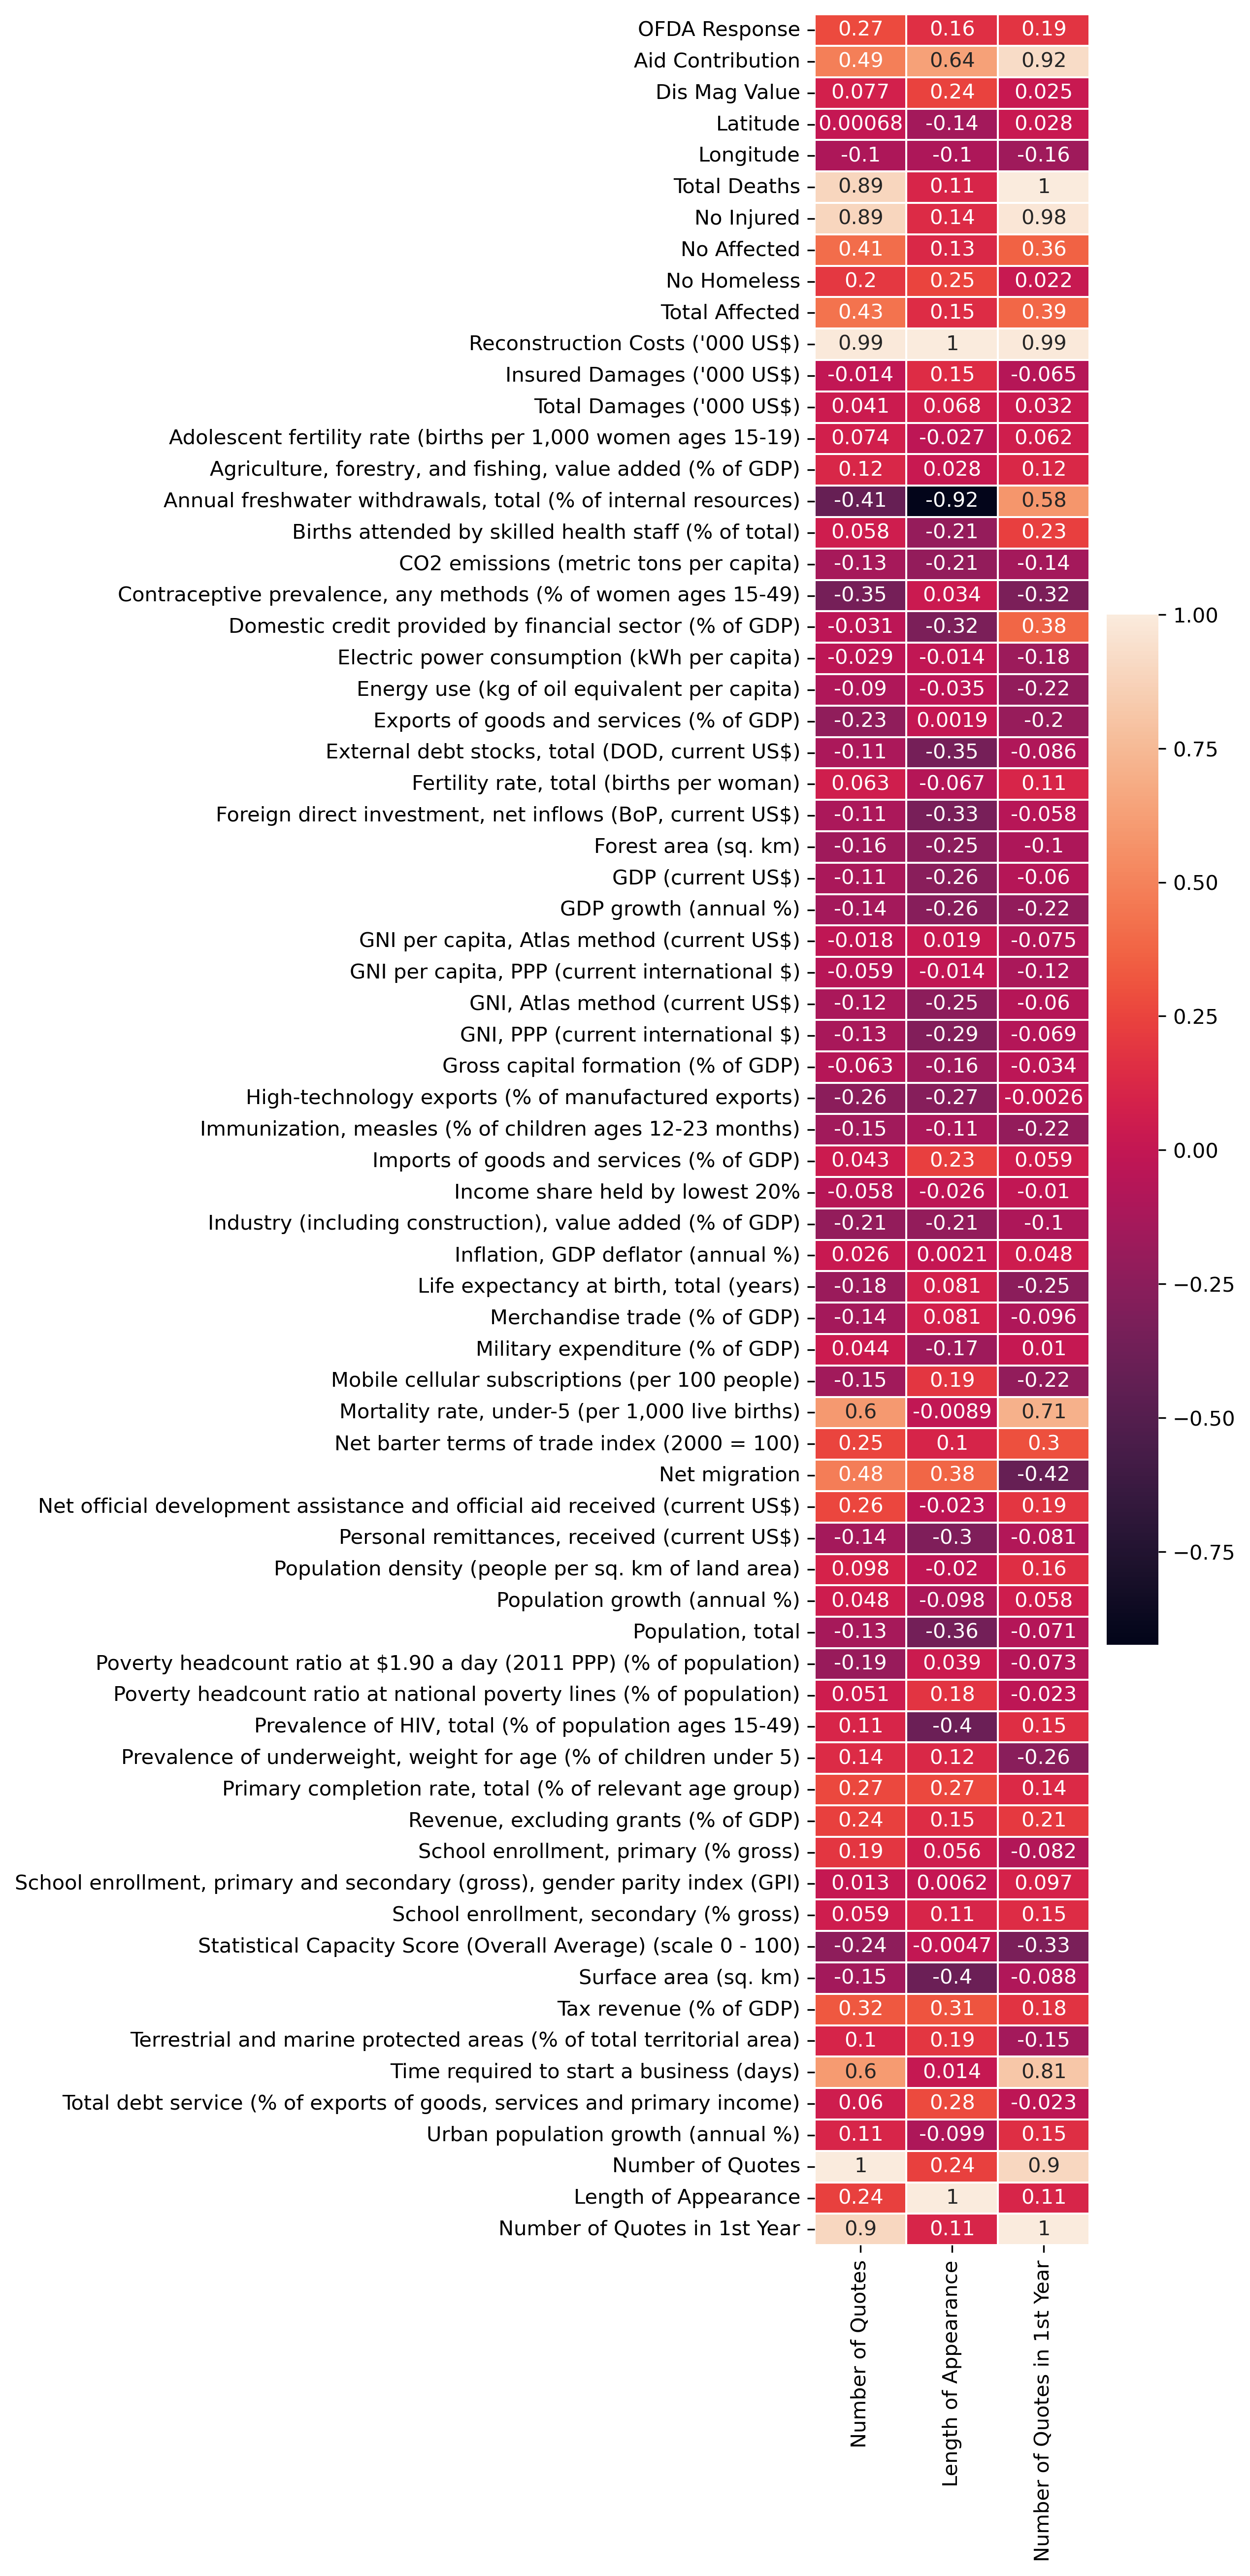

In [278]:
plt.figure(figsize=(3, 20), dpi=300)
sns.heatmap(cor[-3:].T, linewidths=.5, annot=True)
plt.savefig("heatmap.png")